<a href="https://colab.research.google.com/github/BaranovTim/Pytorch_course/blob/main/pytorch_course_YT_3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).



## 1. Make classification data and get it ready

In [ ]:
import sklearn # ML library
from sklearn.datasets import make_circles

#Make a 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [ ]:
print(f'first 5 X:\n {X[:5]}')
print(f'first 5 y:\n {y[:5]}')

first 5 X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


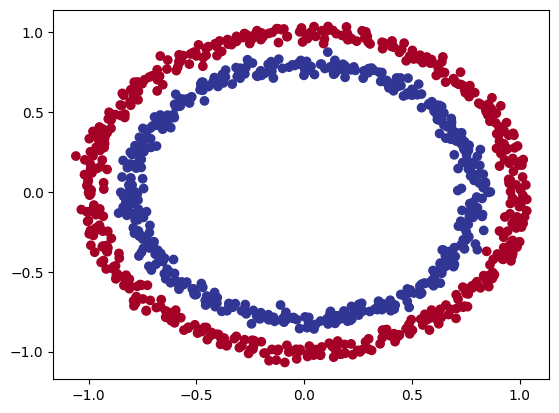

In [ ]:
#Visualize

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu); # cmap - color map = red/yellow/blue


Note: the data we are working with is often referred to as a toy dataset, a dataset that is small enough to practice the fundamentals

### Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
#View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)

[0.75424625 0.23148074] 1


In [ ]:
type(X), X.dtype, y.dtype


(numpy.ndarray, dtype('float64'), dtype('int64'))

In [ ]:
# Turn data into tensors and create train and test splits
import torch
from torch import nn


#split data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be tested and 80% trained
                                                    random_state = 42) # = manual_seed for split

len(X_train), len(X_test), len(y_train), len(y_test)

X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)


In [ ]:
#Building a model (to classify our blue and red dots.)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train

class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    linear_layer_1 = nn.Linear(in_features = 2, out_features = 5)
    linear_layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x: torch.tensor) -> torch.tensor:
    return self.linear_layer_2(self.linear_layer_1(x))


model_0 = CircleModel().to(device)
model_0

CircleModel()

In [ ]:
X_train.shape


torch.Size([800, 2])

In [ ]:
#Let's replicate the model above using nn.Sequential()
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)



In [ ]:
#Make preds
with torch.inference_mode():
  untrained_preds = model(X_test.to(device))


In [ ]:
X_test[:10], y_test[:10]


(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [ ]:
# for the loss func we are going to use torch.nn.BCEWithLogitsLoss() instead of L1Loss
#(it is better for classification)

#loss_func = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_func = nn.BCEWithLogitsLoss() # sigmoid activation function build-in

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)


In [ ]:
#calc accuracy - out of 100 examples, what percentage does our model get right?

def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct/len(y_pred)) * 100 # formula of accuracy from google
  return accuracy


In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))[:5]
y_logits


y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[ 0.5104],
        [ 0.4502],
        [ 0.3559],
        [ 0.5555],
        [-0.1400]])

#for our prediction probability values, we need to perform a range-style rounding them:

* y_pred_probs >= 0.5, y=1 (class 1)
* y_pred_probs < 0.5, y=0 (class 0)


In [ ]:
#Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [ ]:
y_train.shape


torch.Size([800])

In [ ]:
import torch
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()  # Adjust if needed
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_func(y_logits, y_train)
    acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")



Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test loss: 0.69440 | Test acc: 58.00000
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test loss: 0.69305 | Test acc: 53.00000
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test loss: 0.69254 | Test acc: 49.50000
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test loss: 0.69236 | Test acc: 49.50000
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test loss: 0.69232 | Test acc: 51.00000
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test loss: 0.69234 | Test acc: 50.00000
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test loss: 0.69239 | Test acc: 51.50000
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test loss: 0.69246 | Test acc: 51.00000
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test loss: 0.69254 | Test acc: 50.00000
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test loss: 0.69262 | Test acc: 53.00000


# Make predictions and evaluate the model

From the metrics looks like our model is not leeaning anything

So to inspect it let's make some predictions and make them visual

to do so we are going to import a function called plot_decision_boundary()


In [ ]:

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



helper_functions.py already exists, skipping download


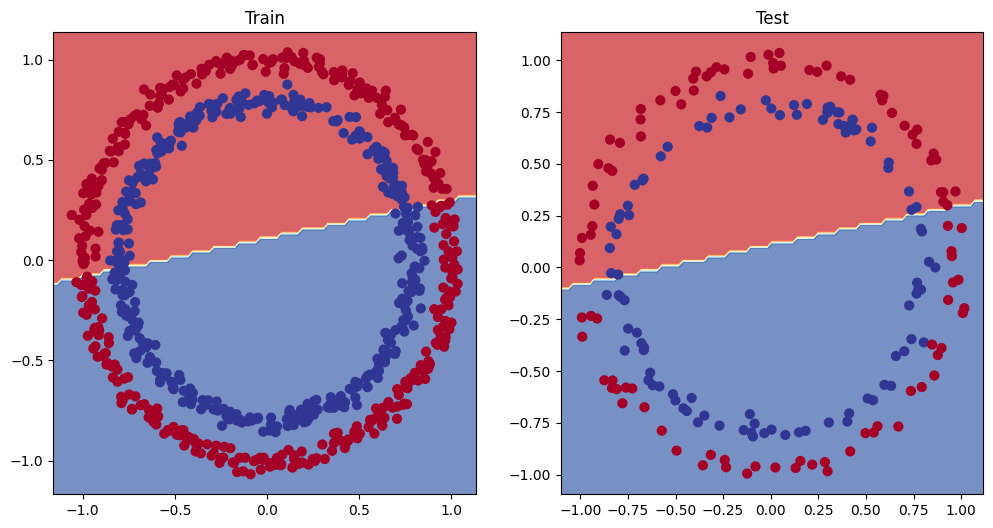

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

### 5. Improving a model (from a model perspective)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
* These options are all from a model's perspective because they deal directly with the model, rather than the data.



And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

Let's try and improve our model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_func = nn.BCEWithLogitsLoss() # sigmoid activation function build-in

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.0001)


torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()  # Adjust if needed
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_func(y_logits, y_train)
    acc = accuracy_func(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_func(test_logits, y_test)
    test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")



Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 100 | Loss: 0.69395, Acc: 50.88% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 200 | Loss: 0.69395, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 300 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 400 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 500 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 600 | Loss: 0.69394, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 700 | Loss: 0.69393, Acc: 50.75% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 800 | Loss: 0.69393, Acc: 50.62% | Test loss: 0.69261 | Test acc: 51.00000
Epoch: 900 | Loss: 0.69393, Acc: 50.62% | Test loss: 0.69261 | Test acc: 51.00000


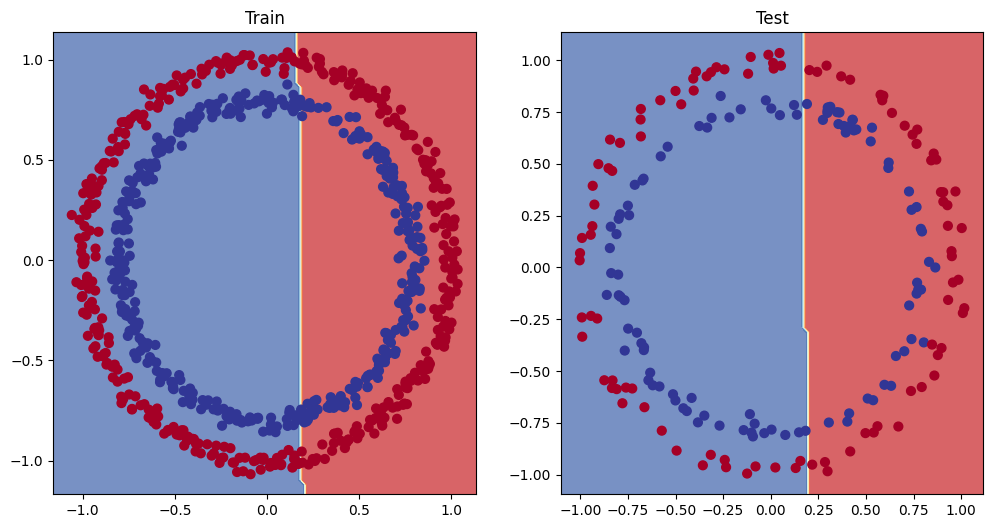

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line
One way to troubleshoot to a larger problem is to test out a smaller problem.

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

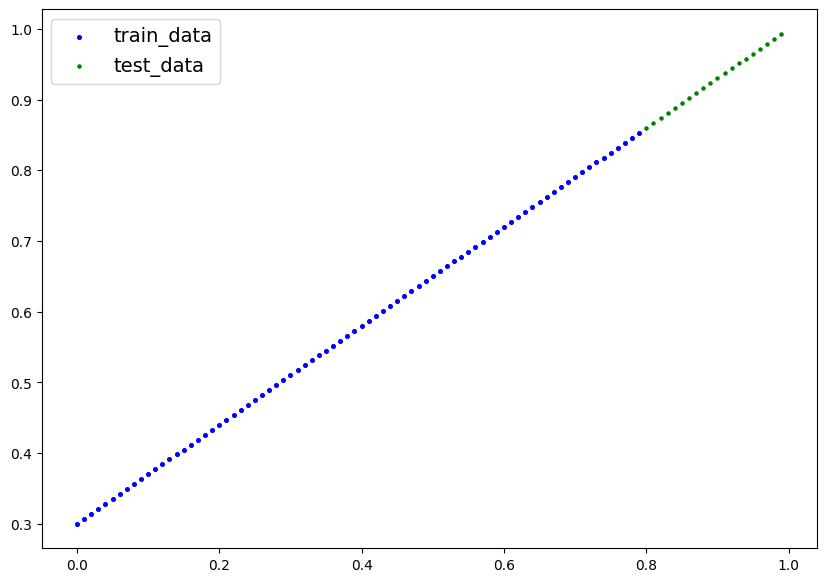

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [ ]:
### Adjusting model_1 to fit the straight line

#Same architecture but using nn.Sequential()

model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_3

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_3(X_train_regression)
  loss = loss_func(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_pred = model_3(X_test_regression)
    test_loss = loss_func(test_pred, y_test_regression)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


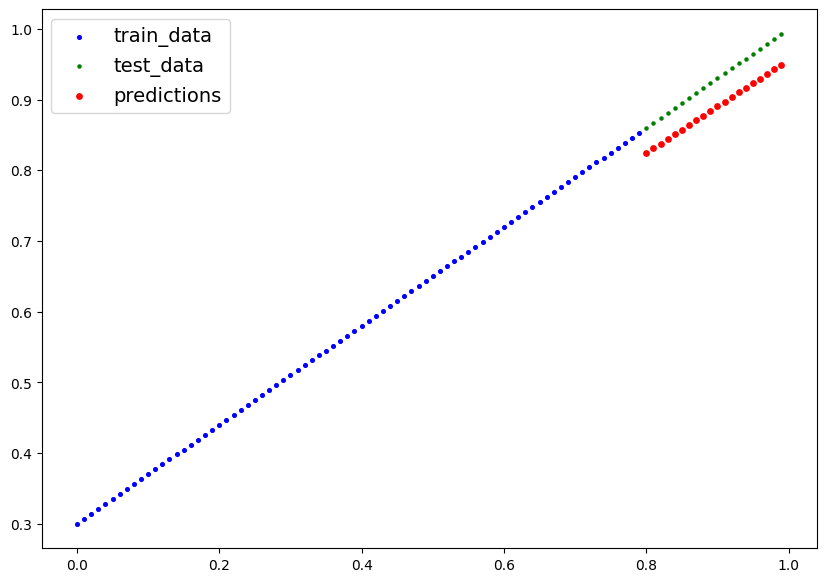

In [ ]:
model_3.eval()

with torch.inference_mode():
   y_preds = model_3(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity
"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

###6.1 Recreating non-linear data (red and blue circles)


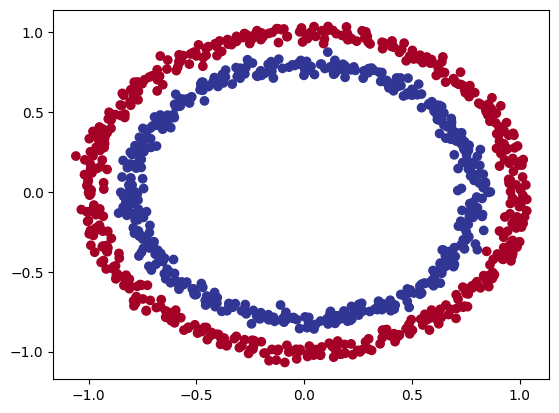

In [ ]:
#Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split


#split into train and test sets

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train[:5], y_train[:5]


(array([[ 0.65794626, -0.46508097],
        [ 0.63194897, -0.7346633 ],
        [-1.00861631, -0.12403051],
        [-0.96657519, -0.22562157],
        [-0.16659009,  0.79944645]]),
 array([1, 0, 0, 0, 1]))

## 6.2 Building a model with non-linearity
Linear = straight lines

Non-linear = non-straight lines


Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [ ]:
#Build a model with non-linear activation functions

from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    #Where should we put our non-linear activation functions
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # between each

model_4 = CircleModelV2().to(device)
model_4

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
## Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)



### 6.3 Training a model with non-linearity

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#X_train = torch.from_numpy(X_train).type(torch.float)
#y_train = torch.from_numpy(y_train).type(torch.float)
#X_test = torch.from_numpy(X_test).type(torch.float)
#y_test = torch.from_numpy(y_test).type(torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs= 1000

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_func(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

# Print out what's this happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.0363, Acc: 99.88% | Test Loss: 0.0598, Test Acc: 100.00%
Epoch: 100 | Loss: 0.0358, Acc: 99.88% | Test Loss: 0.0593, Test Acc: 100.00%
Epoch: 200 | Loss: 0.0353, Acc: 99.88% | Test Loss: 0.0588, Test Acc: 100.00%
Epoch: 300 | Loss: 0.0349, Acc: 99.88% | Test Loss: 0.0582, Test Acc: 100.00%
Epoch: 400 | Loss: 0.0345, Acc: 99.88% | Test Loss: 0.0577, Test Acc: 100.00%
Epoch: 500 | Loss: 0.0340, Acc: 99.88% | Test Loss: 0.0572, Test Acc: 100.00%
Epoch: 600 | Loss: 0.0336, Acc: 99.88% | Test Loss: 0.0567, Test Acc: 100.00%
Epoch: 700 | Loss: 0.0332, Acc: 99.88% | Test Loss: 0.0561, Test Acc: 100.00%
Epoch: 800 | Loss: 0.0328, Acc: 99.88% | Test Loss: 0.0556, Test Acc: 100.00%
Epoch: 900 | Loss: 0.0324, Acc: 99.88% | Test Loss: 0.0551, Test Acc: 100.00%


###6.4 Evaluating a model trained with non-linear activation functions


In [ ]:
# Makes predictions
model_4.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_4(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

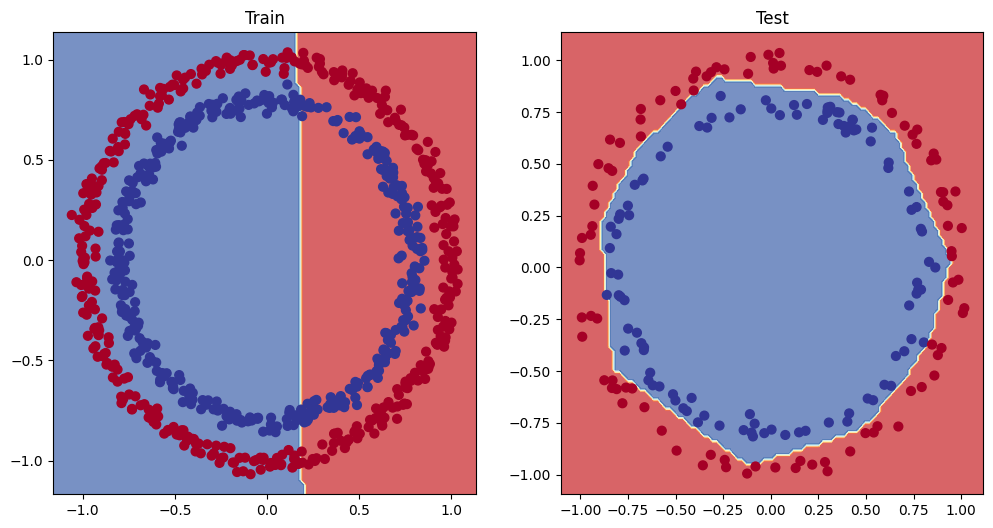

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)#row/column/index
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1.)
A.dtype

torch.float32

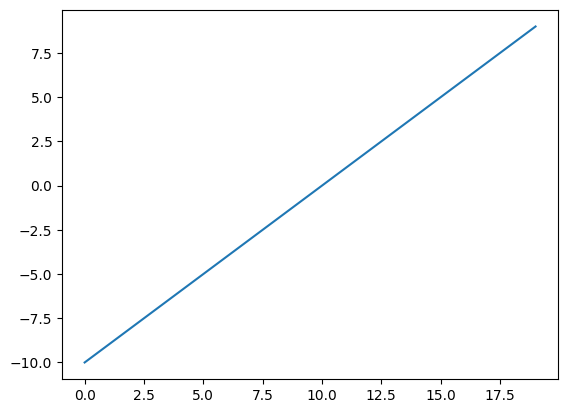

In [ ]:
plt.plot(A)

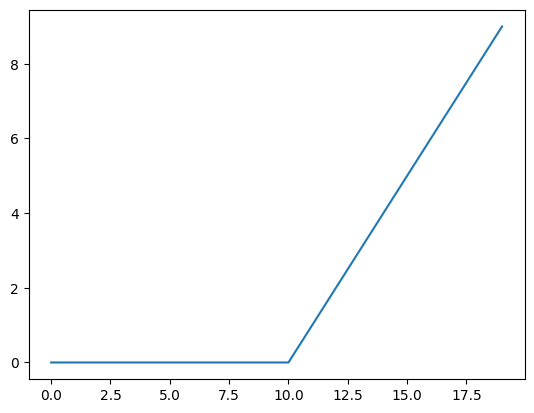

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

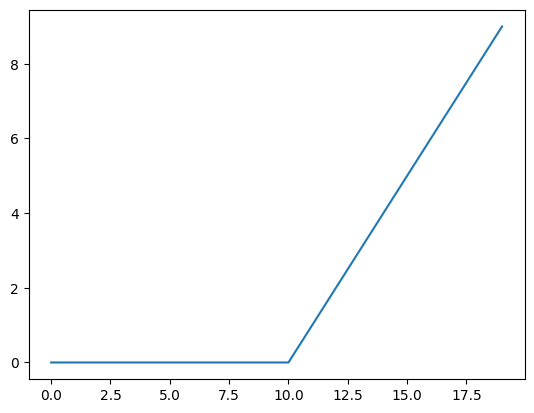

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A));

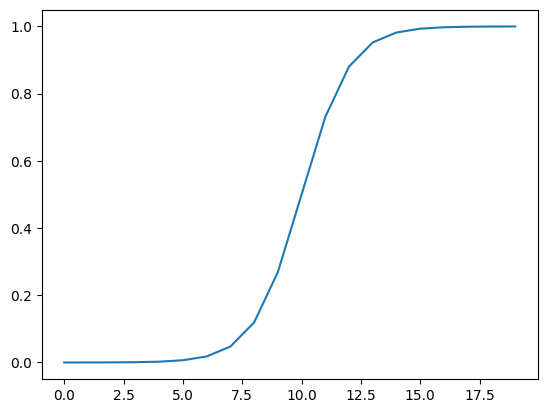

In [ ]:
plt.plot(torch.sigmoid(A))

In [ ]:
# Now let's do the same for Sigmoid = https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

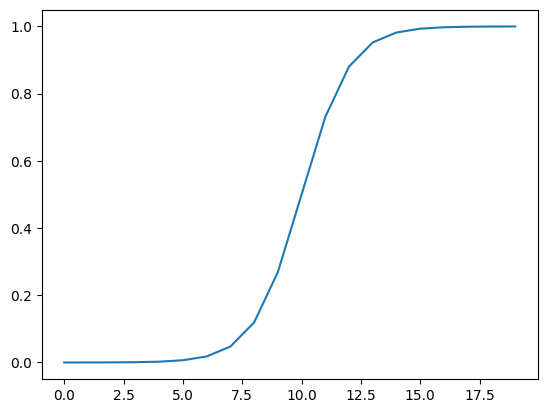

In [ ]:
plt.plot(sigmoid(A));


## 8. Putting it all together with a multi-class classification problem
* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

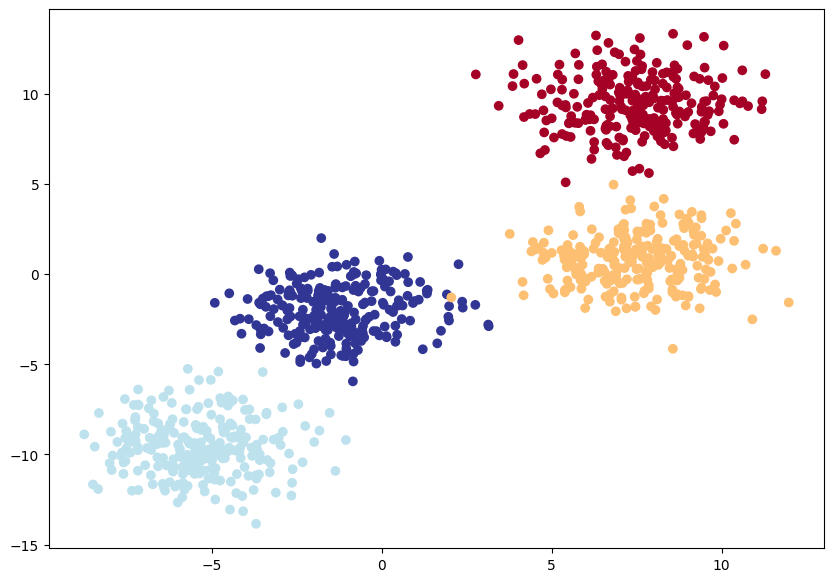

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 8

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, #разброс точек, типо если 0 то тогда они будут друг на друге и как 1 точка будет выглядеть
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)




In [ ]:
y_blob[:5]

tensor([1., 0., 3., 2., 1.])

In [ ]:
# Build a model

device = "cuda" if torch.cuda.is_available() else "cpu"


class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()

    self.linear_layers_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layers_stack(x)

model_5 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_5

BlobModel(
  (linear_layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_func = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.01)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model
In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use torch.softmax) -> Pred labels (take the argmax of the prediction probabilities)

In [ ]:
model_5.eval()
with torch.inference_mode():
  y_logits = model_5(X_blob_test).to(device)

y_logits[:10]

tensor([[ 6.7501e-01,  3.4816e-01,  8.1549e-01,  8.8060e-02],
        [ 1.4638e-01, -2.2382e-03,  1.8212e-01, -6.7368e-02],
        [-2.2529e+00, -1.4832e+00, -2.6767e+00, -8.5517e-01],
        [-2.3739e+00, -1.2420e+00, -2.7754e+00, -1.1328e+00],
        [-1.9337e+00, -1.2990e-01, -2.1296e+00, -1.6213e+00],
        [ 2.2184e+00,  1.2084e+00,  2.6412e+00,  6.6442e-01],
        [-1.6885e+00, -3.2604e-01, -1.8876e+00, -1.2791e+00],
        [ 2.2605e+00,  8.3765e-01,  2.6341e+00,  9.7713e-01],
        [ 1.7171e+00,  6.6947e-01,  2.0107e+00,  6.7270e-01],
        [-1.2035e+00, -3.3906e-01, -1.3548e+00, -8.8454e-01]])

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 6.7501e-01,  3.4816e-01,  8.1549e-01,  8.8060e-02],
        [ 1.4638e-01, -2.2382e-03,  1.8212e-01, -6.7368e-02],
        [-2.2529e+00, -1.4832e+00, -2.6767e+00, -8.5517e-01],
        [-2.3739e+00, -1.2420e+00, -2.7754e+00, -1.1328e+00],
        [-1.9337e+00, -1.2990e-01, -2.1296e+00, -1.6213e+00]])
tensor([[0.2917, 0.2104, 0.3357, 0.1622],
        [0.2698, 0.2326, 0.2797, 0.2179],
        [0.1272, 0.2747, 0.0833, 0.5148],
        [0.1215, 0.3768, 0.0813, 0.4203],
        [0.1080, 0.6557, 0.0888, 0.1476]])


In [ ]:
#Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([2, 2, 3, 3, 1, 2, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 3, 3, 1, 0, 1, 3, 3, 1,
        2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 2,
        2, 2, 2, 2, 3, 2, 1, 3, 2, 1, 2, 1, 2, 2, 1, 2, 3, 2, 3, 2, 1, 2, 2, 2,
        3, 2, 3, 2, 1, 2, 3, 1, 3, 1, 3, 2, 3, 1, 3, 2, 2, 2, 2, 3, 3, 3, 1, 3,
        3, 2, 1, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 3, 1, 3, 1, 2, 1, 2, 3, 2, 1,
        3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 3, 2, 2, 2, 2, 3, 1,
        3, 1, 1, 1, 3, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 0, 1, 1, 2, 1, 2, 2, 1, 3,
        2, 2, 2, 1, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2,
        2, 3, 3, 3, 3, 1, 1, 3])

In [ ]:
y_blob_test

tensor([3., 3., 0., 0., 1., 2., 1., 2., 2., 1., 2., 3., 0., 1., 3., 1., 0., 0.,
        1., 3., 1., 0., 0., 1., 3., 3., 2., 3., 3., 2., 3., 1., 0., 3., 2., 3.,
        3., 3., 3., 3., 2., 3., 3., 1., 1., 3., 0., 2., 2., 2., 2., 2., 0., 3.,
        1., 0., 3., 1., 2., 1., 3., 2., 1., 3., 0., 2., 0., 3., 1., 3., 2., 2.,
        0., 2., 0., 3., 1., 2., 0., 1., 0., 1., 0., 3., 0., 1., 0., 2., 2., 3.,
        2., 0., 0., 0., 1., 0., 0., 3., 1., 0., 1., 2., 2., 0., 2., 3., 1., 3.,
        3., 3., 0., 1., 0., 1., 3., 1., 2., 0., 3., 0., 0., 0., 0., 3., 2., 3.,
        1., 3., 3., 3., 3., 2., 0., 0., 1., 1., 1., 0., 2., 2., 3., 2., 0., 1.,
        0., 1., 1., 1., 0., 3., 3., 3., 2., 2., 1., 2., 2., 0., 1., 3., 1., 1.,
        2., 0., 3., 3., 1., 0., 3., 2., 3., 1., 0., 0., 0., 3., 3., 3., 2., 3.,
        0., 0., 2., 3., 0., 3., 2., 2., 2., 3., 3., 2., 3., 0., 0., 0., 0., 1.,
        1., 0.])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model


In [ ]:
y_logits.size()

torch.Size([800, 4])

In [ ]:
y_blob_train.size()

torch.Size([800])

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device).long()
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device).long()


# Loop through data
for epoch in range(epochs):
  ### Training
  model_5.train()

  y_logits = model_5(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_func(y_logits, y_blob_train)
  acc = accuracy_func(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_5.eval()
  with torch.inference_mode():
    test_logits = model_5(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_func(test_logits, y_blob_test)
    test_acc = accuracy_func(y_true=y_blob_test,
                           y_pred=test_preds)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.0231, Acc: 99.62% | Test loss: 0.0241, Test acc: 99.50%
Epoch: 10 | Loss: 0.0230, Acc: 99.62% | Test loss: 0.0241, Test acc: 99.50%
Epoch: 20 | Loss: 0.0229, Acc: 99.62% | Test loss: 0.0240, Test acc: 99.50%
Epoch: 30 | Loss: 0.0229, Acc: 99.62% | Test loss: 0.0239, Test acc: 99.50%
Epoch: 40 | Loss: 0.0228, Acc: 99.62% | Test loss: 0.0238, Test acc: 99.50%
Epoch: 50 | Loss: 0.0227, Acc: 99.62% | Test loss: 0.0238, Test acc: 99.50%
Epoch: 60 | Loss: 0.0227, Acc: 99.62% | Test loss: 0.0237, Test acc: 99.50%
Epoch: 70 | Loss: 0.0226, Acc: 99.62% | Test loss: 0.0236, Test acc: 99.50%
Epoch: 80 | Loss: 0.0226, Acc: 99.62% | Test loss: 0.0236, Test acc: 99.50%
Epoch: 90 | Loss: 0.0225, Acc: 99.62% | Test loss: 0.0235, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [ ]:
model_5.eval()
with torch.inference_mode():
  y_logits = model_5(X_blob_test)

y_logits[:10]

tensor([[ -7.1139,   0.5616,   5.9594,   8.6648],
        [ -3.0412,   0.9854,  -0.8951,   5.9167],
        [ 14.0125,   3.6618, -30.8002,  -6.1546],
        [ 10.7429,   5.9710, -28.8312,  -5.6055],
        [ -3.3759,  11.2654, -14.0902,  -0.3090],
        [-16.8765,  -1.7959,  24.1799,  16.0915],
        [ -0.5748,   8.6000, -14.8605,  -0.3497],
        [-11.9872,  -4.5744,  20.3357,  14.8484],
        [-10.3115,  -2.8168,  15.4036,  12.7274],
        [  0.0628,   5.9086, -12.2550,   0.9450]])

In [ ]:
#Go from logits to pred prob
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3158e-07, 2.8354e-04, 6.2637e-02, 9.3708e-01],
        [1.2764e-04, 7.1570e-03, 1.0915e-03, 9.9162e-01],
        [9.9997e-01, 3.1971e-05, 3.4522e-20, 1.7438e-09],
        [9.9161e-01, 8.3927e-03, 6.4494e-18, 7.8757e-08],
        [4.3790e-07, 9.9999e-01, 9.7322e-12, 9.4034e-06],
        [1.4767e-18, 5.2327e-12, 9.9969e-01, 3.0697e-04],
        [1.0359e-04, 9.9977e-01, 6.4731e-11, 1.2974e-04],
        [9.1309e-15, 1.5131e-11, 9.9588e-01, 4.1218e-03],
        [6.3559e-12, 1.1431e-08, 9.3561e-01, 6.4394e-02],
        [2.8637e-03, 9.9022e-01, 1.2805e-08, 6.9199e-03]])

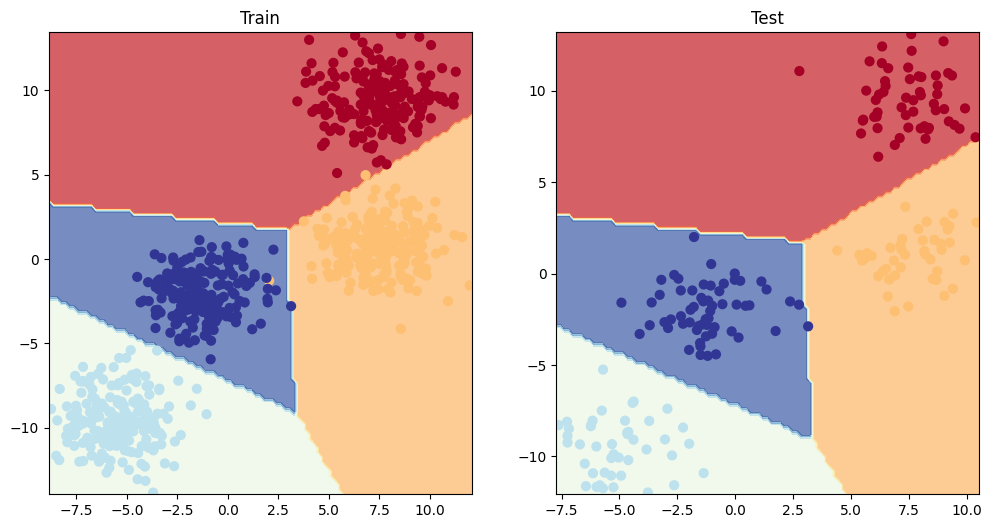

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)
* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'